In [ ]:
# from google.colab import runtime
# runtime.unassign()

In [ ]:
# ! pip list

In [ ]:
# ! pip install imageio opencv-python

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
path = "./drive/MyDrive/Project/Lip_reading/raw_data/"

In [ ]:
test_path = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbal6n.mpg"

## Video Loading Test

In [ ]:
# Get the video
cap = cv2.VideoCapture(test_path)


array([[[ 88,  65,  56],
        [ 89,  66,  57],
        [106,  64,  58],
        ...,
        [ 55,  30,  21],
        [ 54,  29,  22],
        [ 54,  29,  22]],

       [[212, 189, 180],
        [212, 189, 180],
        [231, 189, 183],
        ...,
        [118,  93,  84],
        [117,  92,  85],
        [117,  92,  85]],

       [[240, 216, 109],
        [241, 217, 110],
        [255, 217, 110],
        ...,
        [129, 111,  40],
        [127, 109,  39],
        [127, 109,  39]],

       ...,

       [[151, 122,  19],
        [151, 122,  19],
        [160, 120,  22],
        ...,
        [102,  83,   4],
        [101,  81,   5],
        [101,  81,   5]],

       [[150, 122,  17],
        [151, 123,  18],
        [160, 121,  20],
        ...,
        [101,  82,   3],
        [101,  81,   5],
        [100,  80,   4]],

       [[150, 122,  17],
        [151, 123,  18],
        [159, 120,  19],
        ...,
        [101,  82,   3],
        [100,  80,   4],
        [100,  80,   4]]], dtype=uint8)
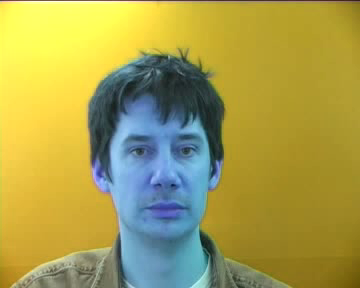

In [ ]:
# Get 1 frame with each iteration
ret, frame = cap.read()
# Display the frame
frame


In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

array([[146, 146, 147, ..., 121, 120, 117],
       [146, 146, 147, ..., 121, 117, 116],
       [146, 146, 145, ..., 118, 118, 118],
       ...,
       [137, 137, 137, ..., 112, 111, 111],
       [137, 137, 137, ..., 111, 110, 110],
       [137, 137, 137, ..., 111, 110, 110]], dtype=uint8)
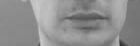

In [ ]:
gray[190:236,80:220]

In [ ]:
gray = tf.image.rgb_to_grayscale(frame)

In [ ]:
# Release the video
cap.release()

## Video Loading Function

In [3]:
def load_video(path: str) -> tf.Tensor:
    '''
    Load a video from a path, convert it to grayscale, crop it to the face,
    normalize it with z-score normalization, and return a numpy array of the frames.
    '''
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
      # Get one frame as a numpy array
      ret, frame = cap.read()
      # Grayscale conversion
      #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # => Returns 2D image
      gray = tf.image.rgb_to_grayscale(frame) # => Returns 3D tensor
      # Add the frame to the list
      frames.append(gray[190:236, 80:220, :])
    # Release the video
    cap.release()

    # Normalize the data with z-score normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    return tf.cast((frames - mean), tf.float32) / std


In [ ]:
frames_test = load_video(test_path)

In [ ]:
type(frames_test)

tensorflow.python.framework.ops.EagerTensor

## Char Encoding

In [4]:
# Vocabulary to encode
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [5]:
# Char to num converter
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Num to char converter
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

### Conversion Test

In [ ]:
# Conversion test
char_to_num(['g', 'a', 'b', 'e'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([7, 1, 2, 5])>

In [ ]:
# Retrieving chars test
num_to_char([7, 1, 2, 5])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'g', b'a', b'b', b'e'], dtype=object)>

## Alignments Loading Test

In [ ]:
! ls drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1/

bbaf2n.align  bwbg8n.align  lrik4p.align  pgwe6n.align	sbwo1s.align
bbaf3s.align  bwbg9s.align  lrik5a.align  pgwe7s.align	sbwo2p.align
bbaf4p.align  bwbh1a.align  lriq6n.align  pgwe8p.align	sbwo3a.align
bbaf5a.align  bwbhzp.align  lriq7s.align  pgwe9a.align	sbwozn.align
bbal6n.align  bwbn2n.align  lriq8p.align  pgwl1s.align	sbwu4n.align
bbal7s.align  bwbn3s.align  lriq9a.align  pgwl2p.align	sbwu5s.align
bbal8p.align  bwbn4p.align  lriy1s.align  pgwl3a.align	sbwu6p.align
bbal9a.align  bwbn5a.align  lriy2p.align  pgwlzn.align	sbwu7a.align
bbas1s.align  bwbt6n.align  lriy3a.align  pgwr4n.align	sgac2n.align
bbas2p.align  bwbt7s.align  lriyzn.align  pgwr5s.align	sgac3s.align
bbas3a.align  bwbt8p.align  lrwf1s.align  pgwr6p.align	sgac4p.align
bbaszn.align  bwbt9a.align  lrwf2p.align  pgwr7a.align	sgac5a.align
bbaz4n.align  bwig1s.align  lrwf3a.align  pgwy8n.align	sgai6n.align
bbaz5s.align  bwig2p.align  lrwfzn.align  pgwy9s.align	sgai7s.align
bbaz6p.align  bwig3a.align  lrwl4n.align  pgwz1a

In [ ]:
al_path = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1/bbaf2n.align"

In [ ]:
# Open align file
with open(al_path + "/bbal6n.align", "r") as f:
    lines = f.readlines()

In [ ]:
lines

['0 16000 sil\n',
 '16000 21250 bin\n',
 '21250 26750 blue\n',
 '26750 27750 at\n',
 '27750 31500 l\n',
 '31500 39250 six\n',
 '39250 45250 now\n',
 '45250 74500 sil\n']

In [ ]:
# Tokienize alignments
tokens = []
for line in lines:
    line = line.split()
    # Ignore silence tokens
    if line[2] != "sil":
        tokens = [*tokens, ' ', line[2]]

tokens

[' ', 'bin', ' ', 'blue', ' ', 'at', ' ', 'l', ' ', 'six', ' ', 'now']

## Alignments Loading Function

In [6]:
def load_alignments(path: str) -> tf.Tensor:
  '''
  Load alignments from a path, tokenize them,
  and return the encoded characters as a 1D tensor.
  '''
  # Open align file
  with open(path, "r") as f:
    lines = f.readlines()

  # Tokenize alignments
  tokens = []
  for line in lines:
      line = line.split()
      # Ignore silence tokens
      if line[2] != "sil":
          tokens = [*tokens, ' ', line[2]]

  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

### Test

In [ ]:
x = load_alignments(al_path)

In [ ]:
x

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [ ]:
num_to_char(x)

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'f', b' ', b't', b'w', b'o', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [30]:
from ctypes import alignment
path = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1"

alignments = []

for file in os.listdir(path):
  alignment = load_alignments(os.path.join(path, file))
  alignments.append(alignment)
  print(f"Loaded {file}")

Loaded srbi1a.align
Loaded lbbq8n.align
Loaded swbc1s.align
Loaded lbwe5s.align
Loaded bbaszn.align
Loaded pgwl1s.align
Loaded lwbs1s.align
Loaded bbiz3a.align
Loaded sbbh2n.align
Loaded prii6n.align
Loaded lbwlzp.align
Loaded sbia2p.align
Loaded lgil6p.align
Loaded bgau1a.align
Loaded bgia5a.align
Loaded bwat4p.align
Loaded pgad8n.align
Loaded lbbezn.align
Loaded pbwj4p.align
Loaded lrbl1s.align
Loaded bbal8p.align
Loaded lgal8n.align
Loaded pbib7s.align
Loaded lwbf5a.align
Loaded lriy3a.align
Loaded bbwm7a.align
Loaded lbwy9a.align
Loaded srbo5a.align
Loaded lgbs9a.align
Loaded bwan1a.align
Loaded bwim4n.align
Loaded lbwe6p.align
Loaded srbo4p.align
Loaded bwag5s.align
Loaded swavzp.align
Loaded bgin3a.align
Loaded bbil4p.align
Loaded bril8n.align
Loaded brba1a.align
Loaded pwwe1s.align
Loaded prbqzp.align
Loaded srwb9s.align
Loaded pwaj6n.align
Loaded pgaq9a.align
Loaded lbbr1a.align
Loaded prbj7a.align
Loaded swwp2n.align
Loaded prbq1a.align
Loaded sgic1a.align
Loaded bbil2n.align


In [36]:
max_len = max([tf.shape(tensor)[0].numpy() for tensor in alignments])
print("Longest alignment length:", max_len)

Longest alignment length: 31


## Load Data Function

In [41]:
tf.convert_to_tensor(path).numpy().decode('utf-8')

'./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1'

In [23]:
def load_data(path: str):
  '''
  Take a path as a tensor, load the video and corresponding alignments,
  and return two tensors, one for the processed frames,
  one for the encoded tokens.
  '''
  # Convert the path back into a string
  path = bytes.decode(path.numpy())

  # Get file name from path
  file_name = path.split('/')[-1].split('.')[0]

  # Get path from file name
  video_path = os.path.join(p, 'videos', 's1',f'{file_name}.mpg')
  alignment_path = os.path.join(p,'alignments','s1',f'{file_name}.align')

  # Load data
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

### Load Test

In [8]:
f, a = load_data("bbaf2n")

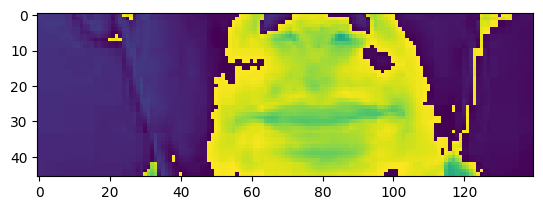

In [51]:
plt.imshow(f[0])

In [11]:
a

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [26]:
path = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1"

In [29]:
videos = []
alignments = []

for file in os.listdir(path):
  # frames, alignment = load_data(os.path.join(path, file))
  # videos.append(frames)
  # alignments.append(alignment)
  print(f"Loaded {file}")

Loaded srbi1a.align
Loaded lbbq8n.align
Loaded swbc1s.align
Loaded lbwe5s.align
Loaded bbaszn.align
Loaded pgwl1s.align
Loaded lwbs1s.align
Loaded bbiz3a.align
Loaded sbbh2n.align
Loaded prii6n.align
Loaded lbwlzp.align
Loaded sbia2p.align
Loaded lgil6p.align
Loaded bgau1a.align
Loaded bgia5a.align
Loaded bwat4p.align
Loaded pgad8n.align
Loaded lbbezn.align
Loaded pbwj4p.align
Loaded lrbl1s.align
Loaded bbal8p.align
Loaded lgal8n.align
Loaded pbib7s.align
Loaded lwbf5a.align
Loaded lriy3a.align
Loaded bbwm7a.align
Loaded lbwy9a.align
Loaded srbo5a.align
Loaded lgbs9a.align
Loaded bwan1a.align
Loaded bwim4n.align
Loaded lbwe6p.align
Loaded srbo4p.align
Loaded bwag5s.align
Loaded swavzp.align
Loaded bgin3a.align
Loaded bbil4p.align
Loaded bril8n.align
Loaded brba1a.align
Loaded pwwe1s.align
Loaded prbqzp.align
Loaded srwb9s.align
Loaded pwaj6n.align
Loaded pgaq9a.align
Loaded lbbr1a.align
Loaded prbj7a.align
Loaded swwp2n.align
Loaded prbq1a.align
Loaded sgic1a.align
Loaded bbil2n.align


# Pipeline

In [15]:
! ls drive/MyDrive/Project/Lip_reading/raw_data/videos/

s1


In [16]:
data = tf.data.Dataset.list_files(
    './drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/*.mpg'
)

In [20]:
data = data.shuffle(500, reshuffle_each_iteration=False)

In [37]:
data

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>